### This notebook is demo for dynamic texture synthesis via auto-regresion of the frame sequence

In [1]:
import urllib

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

    100% |████████████████████████████████| 483.0MB 52.0MB/s 
    100% |████████████████████████████████| 2.0MB 2.1MB/s 
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.46 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.46 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.


In [0]:
!pip install --no-cache-dir -I pillow

In [0]:
from skimage import io
import cv2
import os
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from IPython.core.display import clear_output
from IPython.core.debugger import set_trace
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
cd ./gdrive/My\ Drive/Colab Notebooks/two-stream-dyntex-synth

/content/gdrive/My Drive/Colab Notebooks/two-stream-dyntex-synth


# Define model

In [0]:
class CNN3D(nn.Module):
  
  def __init__(self):
    
    super(CNN3D, self).__init__()
    
    self.d_conv1 = nn.Conv3d(3,64, (2,3,3), stride=1, padding=(0,1,1), bias=True)
    self.d_bn_1 = nn.BatchNorm3d(64)
    self.d_pool1 = nn.MaxPool3d((1,2,2), stride = (1,2,2))
    
    self.d_conv2 = nn.Conv3d(64, 128, (2,3,3), stride=1, padding=(0,1,1), bias=True)
    self.d_bn_2 = nn.BatchNorm3d(128)
    self.d_pool2 = nn.MaxPool3d((1,2,2), stride = (1,2,2))

    self.d_conv3 = nn.Conv3d(128, 256, (1,3,3), stride=1, padding=(0,1,1), bias=True)
    self.d_bn_3 = nn.BatchNorm3d(256)
    self.d_pool3 = nn.MaxPool3d((1,2,2), stride = (1,2,2))
    
    self.d_conv4 = nn.Conv3d(256, 512, (1,3,3), stride=1, padding=(0,1,1), bias=True)
    self.d_bn_4 = nn.BatchNorm3d(512)
    self.d_pool4 = nn.MaxPool3d((1,2,2), stride = (1,2,2))
        
    
    self.u_unconv1 = nn.ConvTranspose2d(512, 256, (2,2), stride = 2, bias=True)
    self.u_conv1 = nn.Conv2d(256, 256, (3,3), stride = 1, padding=(1,1), bias=True)
    
    self.u_unconv2 = nn.ConvTranspose2d(256, 128, (2,2), stride = 2, bias=True)
    self.u_conv2= nn.Conv2d(128, 128, (3,3), stride = 1, padding=(1,1), bias=True)
    
    self.u_unconv3 = nn.ConvTranspose2d(128, 64, (2,2), stride = 2, bias=True)
    self.u_conv3 = nn.Conv2d(64, 64, (3,3), stride = 1, padding=(1,1), bias=True)

    self.u_unconv4 = nn.ConvTranspose2d(64,3, (1,1), stride = 1, bias=True)
    self.u_conv4 = nn.Conv2d(3, 3, (1,1), stride = 1, bias=True)

    self.relu = nn.LeakyReLU()
        
  def forward(self, x):

    x = self.d_conv1(x)
#     self.res1 = x
#     x = self.d_bn_1(x)
    x = self.d_pool1(x)
    x = self.relu(x)
    
    x = self.d_conv2(x)
#     self.res2 = x
#     x = self.d_bn_2(x)
    x = self.d_pool2(x)
    x = self.relu(x)
    
    x = self.d_conv3(x)
#     self.res3 = x
#     x = self.d_bn_3(x)
    x = self.d_pool3(x)
    x = self.relu(x)
    
    x = self.d_conv4(x)
#     self.res4 = x
#     x = self.d_bn_4(x)
    x = self.relu(x)
    
    x = x.reshape(x.shape[0],
                  x.shape[1], x.shape[-1], x.shape[-1])
    
    x = self.u_unconv1(x)
    x = self.u_conv1(x)
    x = self.relu(x)
    
    x = self.u_unconv2(x)
    x = self.u_conv2(x)
    x = self.relu(x)
    
    x = self.u_unconv3(x)
    x = self.u_conv3(x)
    x = self.relu(x)
    
    x = self.u_unconv4(x)
    x = self.u_conv4(x)
    x = self.relu(x)    
    
    return x
  

In [0]:
# X = torch.randn((4, 3, 3, 256, 256))

# model = CNN3D()
# model.forward(X).shape

аугментация, больше обучающая выборка, попробовать обучаться на всем, генерация 3D из гармоник через инстанс норм, идея с optical flow и refine сеткой

In [0]:
def get_seq(fold, seq_len, i):
  
  names = sorted(os.listdir(fold))

  imgs = []
  
  y = io.imread(os.path.join(fold, names[i+seq_len])).transpose(2,0,1)

  for name in names[i:i+seq_len]:

    imgs += [io.imread(os.path.join(fold, name)).transpose(2,0,1)]
    
  imgs = np.array([imgs]).transpose(0,2,1,3,4)
  
  return torch.squeeze(torch.Tensor(imgs)), torch.Tensor(y)
  
    
def deprocess(img_tensor):
  
  return img_tensor[0].detach().cpu().numpy().astype('uint8').transpose(1,2,0)    

In [0]:
# X,y = get_seq('./data/dynamic_textures/water_1/', 6 ,0)

# X.shape, y.shape

# model.forward(X.view(1,*X.shape).cuda()).shape

In [0]:
class DynTexDataset(Dataset):
  
    def __init__(self, root_dir, texture_names, seq_len, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        self.texture_names = texture_names
        self.texture_seqlen_dict = {}
        self.seq_len = seq_len

        for name in texture_names:

            texture_fold = os.path.join(root_dir, name)
            n_framesets = len(os.listdir(texture_fold)) - (seq_len + 1)
            self.texture_seqlen_dict[texture_fold] = n_framesets

    def __getitem__(self, idx):

        new_idx = idx

        for texture_fold in self.texture_seqlen_dict.keys():

          if new_idx < self.texture_seqlen_dict[texture_fold]:
              break
          else:
              new_idx -= self.texture_seqlen_dict[texture_fold]
                      
        return get_seq(texture_fold, self.seq_len, new_idx)

    def __len__(self):

        s = 0
        for fold in self.texture_seqlen_dict.keys():
            s+=self.texture_seqlen_dict[fold]
        return s


# Train model

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30


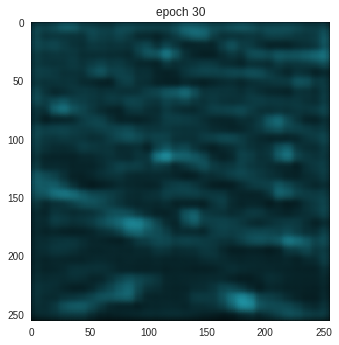

epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60


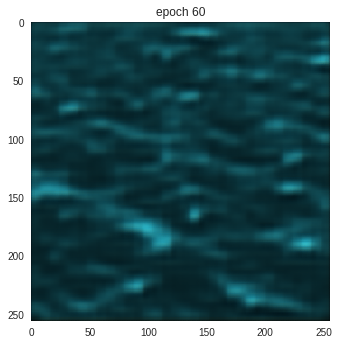

epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90


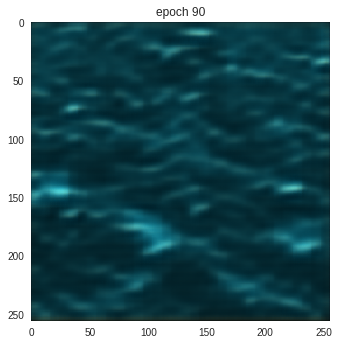

epoch 91
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99
epoch 100
epoch 101
epoch 102
epoch 103
epoch 104
epoch 105
epoch 106
epoch 107
epoch 108
epoch 109
epoch 110
epoch 111
epoch 112
epoch 113
epoch 114
epoch 115
epoch 116
epoch 117
epoch 118
epoch 119
epoch 120


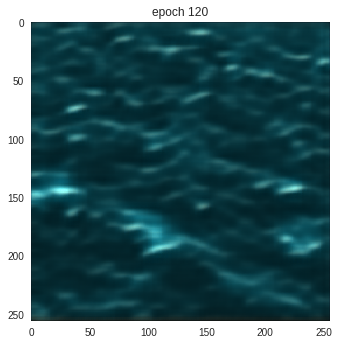

epoch 121
epoch 122
epoch 123
epoch 124
epoch 125
epoch 126
epoch 127
epoch 128
epoch 129
epoch 130
epoch 131
epoch 132
epoch 133
epoch 134
epoch 135
epoch 136
epoch 137
epoch 138
epoch 139
epoch 140
epoch 141
epoch 142
epoch 143
epoch 144
epoch 145
epoch 146
epoch 147
epoch 148
epoch 149
epoch 150


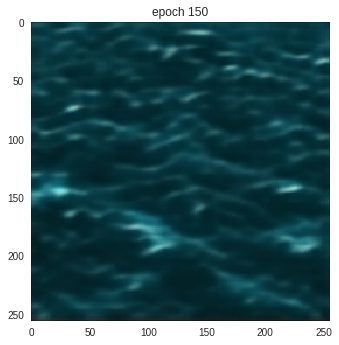

epoch 151
epoch 152
epoch 153
epoch 154
epoch 155
epoch 156
epoch 157
epoch 158
epoch 159
epoch 160
epoch 161
epoch 162
epoch 163
epoch 164
epoch 165
epoch 166
epoch 167
epoch 168
epoch 169
epoch 170
epoch 171
epoch 172
epoch 173
epoch 174
epoch 175
epoch 176
epoch 177
epoch 178
epoch 179
epoch 180


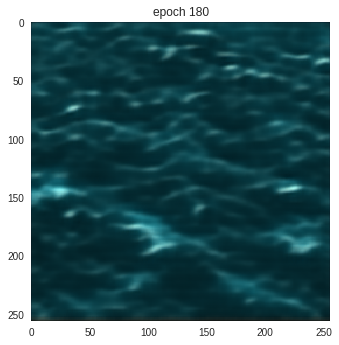

epoch 181
epoch 182
epoch 183
epoch 184
epoch 185
epoch 186
epoch 187
epoch 188
epoch 189
epoch 190
epoch 191
epoch 192
epoch 193
epoch 194
epoch 195
epoch 196
epoch 197
epoch 198
epoch 199
epoch 200
epoch 201
epoch 202
epoch 203
epoch 204
epoch 205
epoch 206
epoch 207
epoch 208
epoch 209
epoch 210


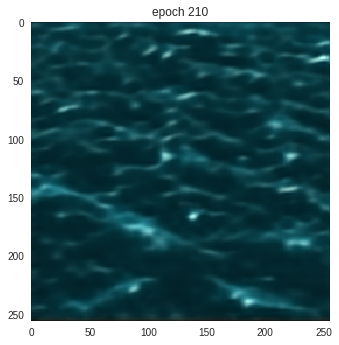

epoch 211
epoch 212
epoch 213
epoch 214
epoch 215
epoch 216
epoch 217
epoch 218
epoch 219
epoch 220
epoch 221
epoch 222
epoch 223
epoch 224
epoch 225
epoch 226
epoch 227
epoch 228
epoch 229
epoch 230
epoch 231
epoch 232
epoch 233
epoch 234
epoch 235
epoch 236
epoch 237
epoch 238
epoch 239
epoch 240


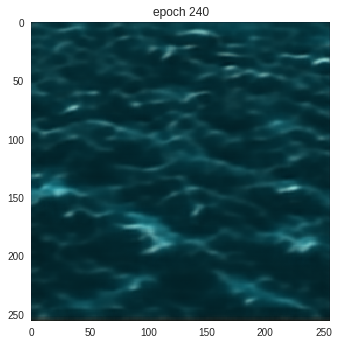

epoch 241
epoch 242
epoch 243
epoch 244
epoch 245
epoch 246
epoch 247
epoch 248
epoch 249
epoch 250
epoch 251
epoch 252
epoch 253
epoch 254
epoch 255
epoch 256
epoch 257
epoch 258
epoch 259
epoch 260
epoch 261
epoch 262
epoch 263
epoch 264
epoch 265
epoch 266
epoch 267
epoch 268
epoch 269
epoch 270


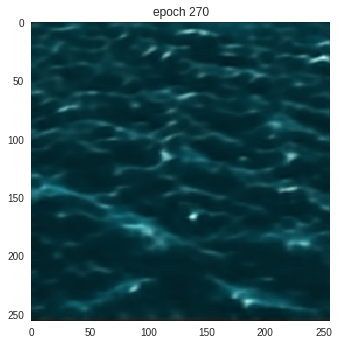

epoch 271
epoch 272
epoch 273
epoch 274
epoch 275
epoch 276
epoch 277
epoch 278
epoch 279
epoch 280
epoch 281
epoch 282
epoch 283
epoch 284
epoch 285
epoch 286
epoch 287
epoch 288
epoch 289
epoch 290
epoch 291
epoch 292
epoch 293
epoch 294
epoch 295
epoch 296
epoch 297
epoch 298
epoch 299



In [15]:
dt = 3
dyntex_data = DynTexDataset('./data/dynamic_textures/', ['water_1'], dt) # , 'water_2', 'water_3', 'water_4', 'water_5'

model = CNN3D()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
eps = 300
freq = eps // 10
batch_size = 1

dataloader = DataLoader(dyntex_data, batch_size=batch_size,
                      shuffle=True, num_workers=5)

losses = []

for ep in tqdm_notebook(range(eps)):
  
  model.train()
  
  for seq_batch, y_batch in dataloader:
    
    seq_batch = seq_batch.cuda()
    y_batch = y_batch.cuda()
    
    optimizer.zero_grad()
    
    pred = model(seq_batch)
    
    loss = torch.norm(y_batch - pred) / batch_size
    loss.backward()
    losses += [loss.detach()]
    
    optimizer.step()
  
  # show
  if ep%freq == 0 and ep > 0:
  
    model.eval()
  
    plt.figure()
    img = pred[0].detach().cpu().numpy()
    img= np.clip(img, 0, 255)
    img = img.astype('uint8')
    
    img = img.transpose(1,2,0)
    
    plt.imshow(img)
    plt.title('epoch {}'.format(ep))
    plt.grid(False)  
    plt.show()


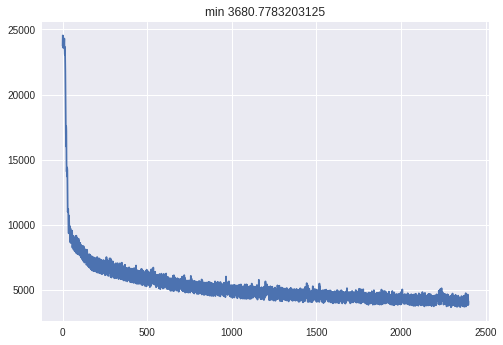

In [17]:
plt.plot(range(len(losses)), losses)
plt.title('min {}'.format(min(losses)))
plt.show()

In [0]:
# torch.save(model.state_dict(), './escalator.pt')

# Use model

In [0]:

# model = CNN3D()
# model.load_state_dict(torch.load('./{}.pt'.format(texture_type)))
# model = model.cuda()

## Generation

In [0]:
texture_type = 'water_1'
fold = './data/dynamic_textures/{}/'.format(texture_type)

target_seq_len = dt
generate_seq_len = 6
path_target = fold

names = sorted(os.listdir(fold))[:-6]

starting_seq, _ = get_seq(path_target, target_seq_len, 0)
current_seq = starting_seq.view(1,*starting_seq.shape).cuda()

generated_imgs = []

for i in tqdm_notebook(range(generate_seq_len)):

    new_img = model(current_seq)

    current_seq = torch.cat([current_seq[:,:,list(range(target_seq_len - 1)),:,:,],
                             new_img.view(1,3,1,256,256)], 2).cuda()
    
    generated_imgs += [deprocess(new_img.detach())]


clear_output()

## Saving

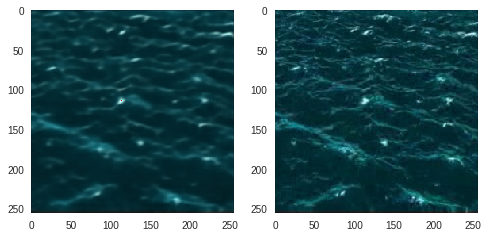

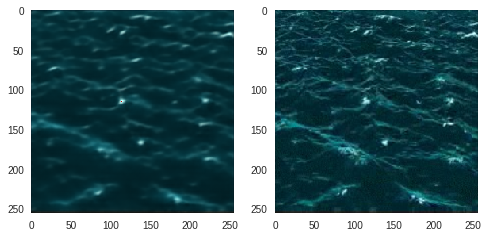

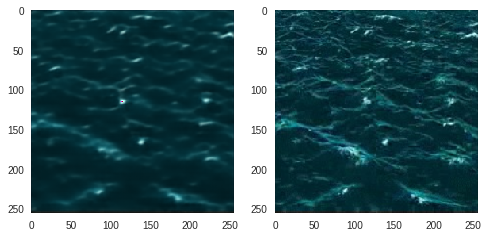

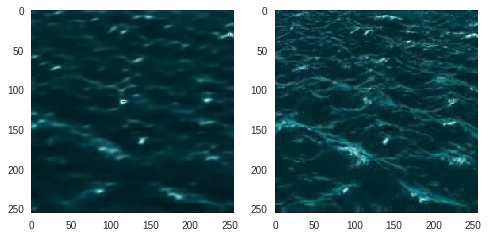

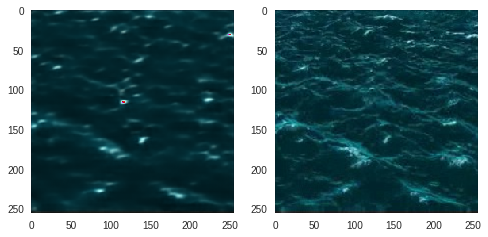

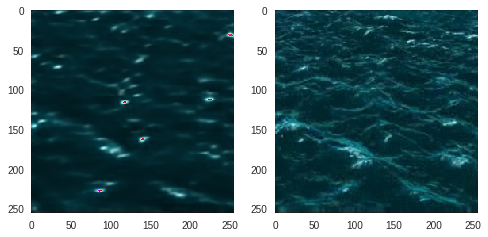

In [21]:
save = False
fold_save = './{}0/'.format(texture_type)
names = sorted(os.listdir(fold))

if save:
    while os.path.isdir(fold_save):

        number = int(re.findall('\d+',fold_save)[-1]) + 1

        fold_save = './{}/'.format(texture_type + str(number)) 

    os.mkdir(fold_save)

for i,img in enumerate(generated_imgs[:6]):
  
    if i + target_seq_len < len(names):
        fig, ax = plt.subplots(ncols=2, nrows=1)
        
        ax[0].imshow(img)
        ax[0].grid(False)
        ax[1].imshow(io.imread(os.path.join(fold, names[i + target_seq_len])))
        ax[1].grid(False)
    else:
        plt.figure()
        plt.imshow(img)

    plt.grid(False)

    if save:
        plt.imsave(fold_save + '{}.jpg'.format(i), img)

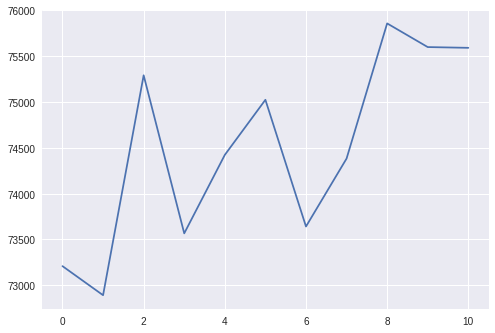

In [77]:
distance = []
img_0 = io.imread(os.path.join(fold, names[0]))

for name in names[1:]:
    
    img_i = io.imread(os.path.join(fold, name))
    distance += [np.linalg.norm(img_0 - img_i)]    
    
plt.plot(range(len(distance)), distance)